In [2]:
import torch

print(f'Cuda available: {torch.cuda.is_available()}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on: {device}, Device count: {torch.cuda.device_count()}')

Cuda available: True
Running on: cuda, Device count: 2


### Fix random seed

In [3]:
import random
import numpy as np

magic_value = 42

torch.manual_seed(magic_value)
torch.cuda.manual_seed(magic_value)

random.seed(magic_value)
np.random.seed(magic_value)

#torch.use_deterministic_algorithms(True)

# This will slightly reduce performance of CUDA convolution
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# thats for dataloader reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(magic_value)

### Dataset loading

In [4]:
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

DATAROOT = 'D:/ThesisProjects/nuScenes_dataset/'
nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)

helper = PredictHelper(nusc)

In [5]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

train_samples = get_prediction_challenge_split("train", dataroot=DATAROOT)
valid_samples = get_prediction_challenge_split("train_val", dataroot=DATAROOT)

In [6]:
import numpy as np

NPY_DATAROOT = './npy_dataset/'

In [7]:
# train_images = np.load(f'{NPY_DATAROOT}train/norm_train_img.npy')
# train_states = np.load(f'{NPY_DATAROOT}train/norm_train_states.npy')
# train_labels = np.load(f'{NPY_DATAROOT}train/train_labels.npy')

train_images = np.load(f'{NPY_DATAROOT}train_img_small.npy')#[:2]
train_states = np.load(f'{NPY_DATAROOT}train_states_small.npy')#[:2]
train_labels = np.load(f'{NPY_DATAROOT}train_labels_small.npy')#[:2]

In [8]:
len(train_images), len(train_states), len(train_labels)

(100, 100, 100)

In [9]:
# valid_images = np.load(f'{NPY_DATAROOT}validation/norm_validation_img.npy')
# valid_states = np.load(f'{NPY_DATAROOT}validation/norm_validation_states.npy')
# valid_labels = np.load(f'{NPY_DATAROOT}validation/validation_labels.npy')

valid_images = np.load(f'{NPY_DATAROOT}valid_img_small.npy')#[:3]
valid_states = np.load(f'{NPY_DATAROOT}valid_states_small.npy')#[:3]
valid_labels = np.load(f'{NPY_DATAROOT}valid_labels_small.npy')#[:3]

In [10]:
len(valid_images), len(valid_states), len(valid_labels)

(100, 100, 100)

In [11]:
# Fix error dot : expected both vectors to have same dtype, but found Double and Float
# Because predictions from MTP in type float32

train_labels = train_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

### Check data

In [11]:
import matplotlib.pyplot as plt

def show_img(img, size=4):
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

array of : <class 'numpy.float16'>


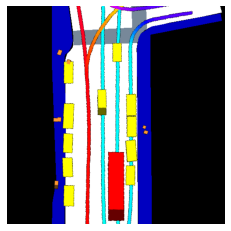

[ 4.8725821  -1.         -0.00872902]

[ 0.03461636  2.435311    0.06848134  4.869962    0.1030977   7.305273
  0.11408295  8.818821    0.12497671 10.330958    0.13662185 11.843756
  0.1476071  13.357304    0.15925224 14.8701      0.15621985 15.555505
  0.15252762 16.241661    0.15024662 16.927727    0.14721423 17.61313   ]


In [13]:
index_to_check = 0

img = train_images[index_to_check]
print(f'array of : {type(img[0])}')

img = img.reshape((500, 500, 3))
img = (img * 255).astype('uint8')

show_img(img)

print(train_states[index_to_check])
print()
print(train_labels[index_to_check])

In [7]:
import random

def plot_path(trajectories, size=6):
    
    plt.figure(figsize=(size, size))
    for trajectory in trajectories:
        
        rand_color = [random.uniform(0.2, 1), random.uniform(0.2, 1), random.uniform(0.2, 1)]
        plt.scatter(trajectory[:, 1], -trajectory[:, 0], color=rand_color, s=10)
    
    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()

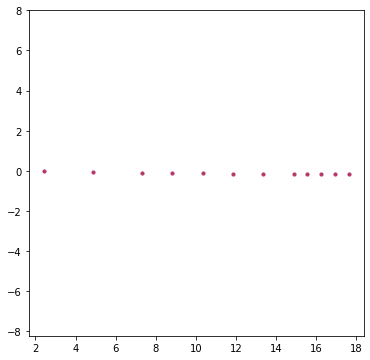

In [16]:
path = train_labels[index_to_check].reshape(12, 2)
plot_path([path])

### Train config

In [17]:
import wandb

wandb.init(
    project='Covernet_1.0',
    entity='techtoker',
    config={    
        "epoch": 13,
        "batch_size": 32,
        "num_modes": 415, # Trajectory set 8 = 64 ;  Trajectory set 4 : 415; Trajectory set 2 : 2206
        "lr":5e-5,
        "weight_decay": 5e-4,
    })

config = wandb.config

wandb: Currently logged in as: techtoker (use `wandb login --relogin` to force relogin)


### Dataset init

In [18]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from typing import List

class NuscenesDataset(Dataset):
    def __init__(self, features: List[str], states: List[str], labels: List[str]):
                            
#         max_velocity = 26.0
#         min_accel = -26.0
#         max_accel = 26.0
#         min_heading_cr = -1.5
#         max_heading_cr = 1.5
        
#         # normalization        
#         velocities = [state[0] / max_velocity for state in states]
#         accel = [(state[1] + abs(min_accel)) / (abs(min_accel) + max_accel) for state in states]
#         heading_cr = [(state[2] + abs(min_heading_cr)) / (abs(min_heading_cr) + max_heading_cr) for state in states]
        
#         for i in range(len(states)):
#             states[i] = np.array([velocities[i], accel[i], heading_cr[i]])
                
        self.features = features
        self.states = states
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index: int):
        image = self.features[index].reshape((500, 500, 3))         
        image = torch.Tensor(image).permute(2, 0, 1)
        
        agent_state_vector = torch.Tensor(self.states[index])
        ground_truth = self.labels[index].reshape((12, 2))

        # Convert to [batch_size, 1, 12, 2]
        # Because loss function need that format
        ground_truth = np.expand_dims(ground_truth, 0)

        return image, agent_state_vector, ground_truth

In [19]:
train_ds = NuscenesDataset(train_images, train_states, train_labels)
train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)

validation_ds = NuscenesDataset(valid_images, valid_states, valid_labels)
validation_dl = DataLoader(validation_ds, batch_size=config.batch_size * 2)

### Trajectory set test

In [38]:
import pickle

# Epsilon is the amount of coverage in the set, 
# i.e. a real world trajectory is at most 8 meters from a trajectory in this set
# We released the set for epsilon = 2, 4, 8. Consult the paper for more information
# on how this set was created

PATH_TO_EPSILON_SET = "./covernet_trajectory_set/epsilon_4.pkl"
trajectories = pickle.load(open(PATH_TO_EPSILON_SET, 'rb'))

#Saved them as a list of lists
trajectories_set = torch.Tensor(trajectories)

In [39]:
len(trajectories_set)

415

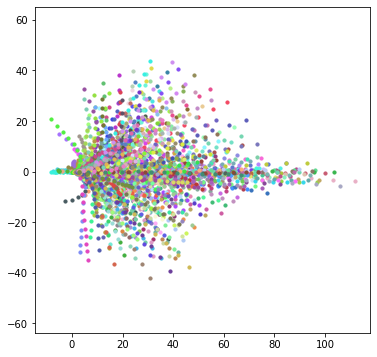

In [12]:
np_trajectories =np.array(trajectories_set)

plot_path(np_trajectories)

### Model init

In [23]:
import importlib
import nuscenes.prediction.models.covernet

importlib.reload(nuscenes.prediction.models.covernet)

<module 'nuscenes.prediction.models.covernet' from 'C:\\Projects\\anaconda3\\lib\\site-packages\\nuscenes\\prediction\\models\\covernet.py'>

In [22]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.covernet import CoverNet, ConstantLatticeLoss

backbone = ResNetBackbone('resnet50')
model = CoverNet(backbone, num_modes=config.num_modes)
model = torch.nn.DataParallel(model)

#model.load_state_dict(torch.load('./'))
model = model.to(device)

2051


In [23]:
from torch.optim import Adam

loss_function = ConstantLatticeLoss(trajectories_set)
optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

In [24]:
model

DataParallel(
  (module): CoverNet(
    (backbone): ResNetBackbone(
      (backbone): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

### Pass example

In [25]:
trajectories_set_np = trajectories_set.cpu().numpy()
trajectories_set_np.shape

(415, 12, 2)

In [26]:
def get_predictions(model, image_tensor, state_tensor):
    
    # TODO: USE IT ONLY AFTER LOSS CALCULATION
    #sm = torch.nn.Softmax(dim=0)
    #mode_probabilities = sm(logits)
        
    logits = model(image_tensor, state_tensor)[0]
        
    sorted_logits_indexes = logits.argsort(descending=True)
        
    sorted_logits = logits[sorted_logits_indexes]
    sorted_logits = sorted_logits.cpu().detach().numpy()
    
    sorted_logits_indexes = sorted_logits_indexes.cpu().detach().numpy()
    sorted_trajectories = trajectories_set_np[sorted_logits_indexes]
    
    return sorted_trajectories, sorted_logits

In [27]:
img, state, _ = next(iter(validation_dl))

img = img[0].unsqueeze(0)
state = state[0].unsqueeze(0)

img.shape, state.shape

(torch.Size([1, 3, 500, 500]), torch.Size([1, 3]))

In [28]:
img_test = img[0].permute(1, 2, 0).cpu().detach().numpy()
img_test.shape

(500, 500, 3)

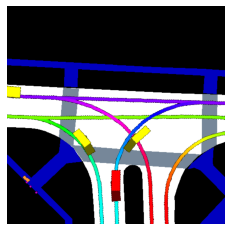

In [29]:
show_img(img_test)

In [30]:
best_traj, prob = get_predictions(model, img, state)

best_traj.shape, prob.shape

((415, 12, 2), (415,))

### Training helpers

In [31]:
import os

# Create folder for all models
dir = os.path.join('./models')
if not os.path.exists(dir):
    os.mkdir(dir)

### TODO: Move it to new class/script/file

In [32]:
from custom_prediction.custom_input_representation.static_layers import StaticLayerRasterizer
from custom_prediction.custom_input_representation.agents import AgentBoxesWithFadedHistory, AgentBoxesWithFutureTrajectory
from custom_prediction.custom_input_representation.interface import InputRepresentation
from custom_prediction.custom_input_representation.combinators import Rasterizer

from typing import Dict
import numpy as np

def generate_scene_visualization(instance_token, sample_token, trajectory_predictions:Dict[str, np.ndarray]):
    #TODO: Move class initialization away from method
    static_layer_rasterizer = StaticLayerRasterizer(helper, colorful_lines=False)
    agent_rasterizer = AgentBoxesWithFutureTrajectory(helper, trajectory_predictions, seconds_of_history=0)

    mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

    img = mtp_input_representation.make_input_representation(instance_token, sample_token)

    return img

In [33]:
def training_sample_vizualization(model, dataset):
    
    index = 0
    img, state, ground_truth = dataset[index]
    instance_token, sample_token = valid_samples[index].split("_")
    
    img = img.unsqueeze(0).to(device)
    state = state.unsqueeze(0).to(device)
  
    # Get model predictions
    sorted_trajectories, mode_probabilities = get_predictions(model, img, state)
        
    amount_of_trajectories = 3
    all_prediction_dict = {instance_token: sorted_trajectories[:amount_of_trajectories]}
    
    instance_token, sample_token = valid_samples[index].split('_')
    img = generate_scene_visualization(instance_token, sample_token, all_prediction_dict)
    show_img(img)

In [34]:
import nuscenes.eval.prediction.metrics as metrics
from collections import defaultdict
from typing import List, Dict, Any


def get_metrics_predictions(model, instance_token, sample_token, img, state):

    img = img.unsqueeze(0).to(device)
    state = state.unsqueeze(0).to(device)

    # Get model predictions
    sorted_trajectories, mode_probabilities = get_predictions(model, img, state)
        
    top_trajectories = sorted_trajectories[:10]
    top_probabilities = mode_probabilities[:10]
    
    # Prediction contains no more than 25 modes. 
    prediction = metrics.Prediction(instance_token, sample_token, top_trajectories, top_probabilities)
    
    return prediction


def get_metrics(model, valid_ds, valid_samples):
    
    # Define metrics function and container
    metric_functions = [metrics.MinFDEK([1, 5], aggregators=[metrics.RowMean()]),
                        metrics.MinADEK([1, 5, 10], aggregators=[metrics.RowMean()]),
                        metrics.MissRateTopK([5, 10], tolerance=2, aggregators=[metrics.RowMean()])]

    num_predictions = len(valid_ds) # Amount of prediction rows (equals of len of validation)
    metrics_container = {metric.name: np.zeros((num_predictions, metric.shape)) for metric in metric_functions}
    
    # Prediction loop
    for idx in tqdm(range(len(valid_ds))):
        feature, state, ground_truth = valid_ds[idx]
        instance_tkn, sample_tkn = valid_samples[idx].split("_")
                        
        # Make prediction
        prediction = get_metrics_predictions(model, instance_tkn, sample_tkn, feature, state)
        
        # Get ground_truth
        gt = ground_truth.reshape((12, 2))

        # Calculate metrics
        for metric in metric_functions:
            metrics_container[metric.name][idx] = metric(gt, prediction)
    
    # Metrics aggregations
    aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

    for metric in metric_functions:
        for agg in metric.aggregators:
            aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

    return aggregations

In [35]:
from tqdm import tqdm
import time

def loss_batch(model, loss_func, img, state_vec, ground_truth, opt=None):
    img = img.to(device)
    state_vec = state_vec.to(device)    
    ground_truth = ground_truth.to(device)
        
    predicted_logits = model(img, state_vec)
    loss = loss_func(predicted_logits, ground_truth)

    # For validation optimizer is None, thus we dont perform backprop
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return losses and amount of items
    return loss.item(), len(img)


def train_step(model, train_dl, loss_func, opt):
    model.train()

    losses = []
    nums = []
    for img, state_vec, gt in tqdm(train_dl):
        loss, num = loss_batch(model, loss_func, img, state_vec, gt, opt)
        losses.append(loss)
        nums.append(num)
        
    # Calculate train loss
    train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    return train_loss


def validation_step(model, valid_dl, loss_func):
    tqdm.write("Validation step")
    time.sleep(0.5)
    
    model.eval()

    with torch.no_grad():
        losses = []
        nums = []
                
        for img, state_vec, gt in tqdm(valid_dl):
            loss, num = loss_batch(model, loss_func, img, state_vec, gt)
            
            losses.append(loss)
            nums.append(num)
        
        # Calculate validation loss
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
#         scheduler_exp.step()
#         scheduler_onPlateau.step(val_loss)
        
    return val_loss


def log_metrics(model, valid_ds, valid_samples, start_epoch_time, best_loss, train_loss, val_loss):
    
    # Calculate metrics on validation set
    tqdm.write("Calculate metrics:")
    time.sleep(0.5)
    
    metricsRes = get_metrics(model, valid_ds, valid_samples)
    
    minFDE_1 = metricsRes['MinFDEK']['RowMean'][0]
    minFDE_5 = metricsRes['MinFDEK']['RowMean'][1]
    minADEK_1 = metricsRes['MinADEK']['RowMean'][0]
    minADEK_5 = metricsRes['MinADEK']['RowMean'][1]
    minADEK_10 = metricsRes['MinADEK']['RowMean'][2]
    missRateTopK2_5 = metricsRes['MissRateTopK_2']['RowMean'][0]
    missRateTopK2_10 = metricsRes['MissRateTopK_2']['RowMean'][1]    

    wandb.log({'Train loss': train_loss,
               'Val loss': val_loss,
               'Learning_rate': optimizer.param_groups[0]['lr'], #scheduler_exp.get_last_lr()[0],
               'minFDE_1': minFDE_1,
               'minFDE_5': minFDE_5,
               'min_ADEK_1': minADEK_1,
               'minADEK_5': minADEK_5,
               'minADEK_10': minADEK_10,
               'missRateTopK2_5':missRateTopK2_5,
               'missRateTopK2_10':missRateTopK2_10
              })
    
    # TODO: Visualization
    training_sample_vizualization(model, valid_ds)
        
    print(f"Epoch {current_epoch + 1}; Train loss: {train_loss:0.2f}; Val loss: {val_loss:0.2f}; Best VL: {best_loss:0.2f}; Time: {(time.time() - start_epoch_time):0.2f} sec;")

In [36]:
import copy

current_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, valid_ds, valid_samples):
    global current_epoch
    global best_model_wts
    
    best_loss = 999.0

    for epoch in range(epochs):
        start_epoch_time = time.time()
        tqdm.write('-' * 30)
        tqdm.write(f'Epoch: {epoch + 1}/{epochs}')
        time.sleep(0.5)
        
        train_loss = train_step(model, train_dl, loss_func, opt)        
        val_loss = validation_step(model, valid_dl, loss_func)  
        
        # deep copy the model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        log_metrics(model, valid_ds, valid_samples, start_epoch_time, best_loss, train_loss, val_loss)
            
        torch.save(copy.deepcopy(model.state_dict()), f'./Models/CoverNet_m415_e{current_epoch}_{best_loss:0.2f}.pth')
        current_epoch += 1

------------------------------
Epoch: 1/13


  0%|                                                                                         | 0/1006 [00:00<?, ?it/s]C:\Projects\anaconda3\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:44<00:00,  1.56it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:53<00:00,  2.50it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [05:24<00:00, 26.34it/s]
C:\Projects\anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Projects\anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


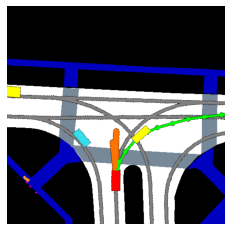

Epoch 1; Train loss: 4.69; Val loss: 4.20; Best VL: 4.20; Time: 1026.56 sec;
------------------------------
Epoch: 2/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [11:12<00:00,  1.50it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:56<00:00,  2.37it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:09<00:00, 45.22it/s]


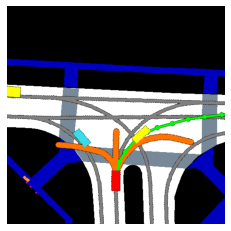

Epoch 2; Train loss: 3.81; Val loss: 3.73; Best VL: 3.73; Time: 922.31 sec;
------------------------------
Epoch: 3/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:41<00:00,  1.57it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:56<00:00,  2.38it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:08<00:00, 45.47it/s]


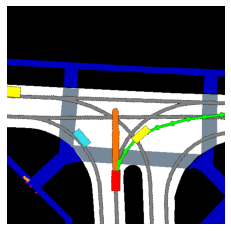

Epoch 3; Train loss: 3.42; Val loss: 3.51; Best VL: 3.51; Time: 889.12 sec;
------------------------------
Epoch: 4/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [14:06<00:00,  1.19it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:57<00:00,  2.34it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:06<00:00, 45.96it/s]


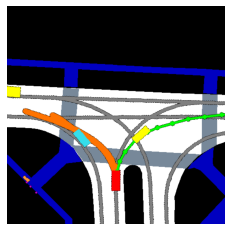

Epoch 4; Train loss: 3.17; Val loss: 3.48; Best VL: 3.48; Time: 1093.02 sec;
------------------------------
Epoch: 5/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [11:40<00:00,  1.44it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [01:28<00:00,  1.51it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:09<00:00, 45.27it/s]


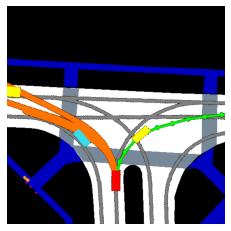

Epoch 5; Train loss: 2.98; Val loss: 3.58; Best VL: 3.48; Time: 980.40 sec;
------------------------------
Epoch: 6/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:36<00:00,  1.58it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:54<00:00,  2.44it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [05:01<00:00, 28.37it/s]


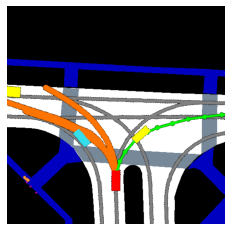

Epoch 6; Train loss: 2.77; Val loss: 3.43; Best VL: 3.43; Time: 995.86 sec;
------------------------------
Epoch: 7/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:49<00:00,  1.55it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [01:02<00:00,  2.15it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:10<00:00, 45.04it/s]


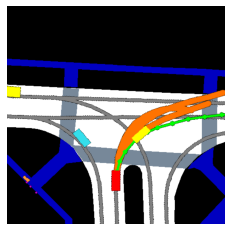

Epoch 7; Train loss: 2.56; Val loss: 3.61; Best VL: 3.43; Time: 904.62 sec;
------------------------------
Epoch: 8/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:34<00:00,  1.59it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:54<00:00,  2.46it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:10<00:00, 45.03it/s]


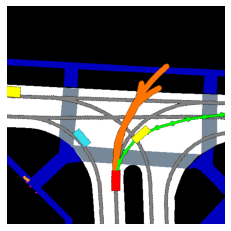

Epoch 8; Train loss: 2.34; Val loss: 3.84; Best VL: 3.43; Time: 881.37 sec;
------------------------------
Epoch: 9/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:38<00:00,  1.58it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:56<00:00,  2.37it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [04:19<00:00, 32.96it/s]


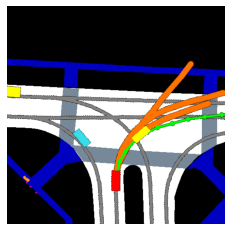

Epoch 9; Train loss: 2.13; Val loss: 4.62; Best VL: 3.43; Time: 957.53 sec;
------------------------------
Epoch: 10/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:59<00:00,  1.53it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [01:17<00:00,  1.73it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:08<00:00, 45.42it/s]


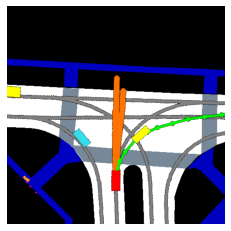

Epoch 10; Train loss: 1.91; Val loss: 4.38; Best VL: 3.43; Time: 927.61 sec;
------------------------------
Epoch: 11/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:29<00:00,  1.60it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:01<00:00,  1.35s/it]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:06<00:00, 45.82it/s]


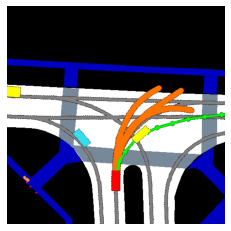

Epoch 11; Train loss: 1.72; Val loss: 5.10; Best VL: 3.43; Time: 999.73 sec;
------------------------------
Epoch: 12/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [11:48<00:00,  1.42it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:56<00:00,  2.36it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:06<00:00, 45.93it/s]


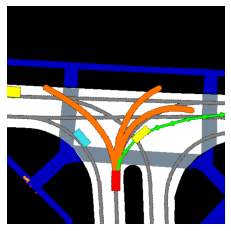

Epoch 12; Train loss: 1.53; Val loss: 4.95; Best VL: 3.43; Time: 954.90 sec;
------------------------------
Epoch: 13/13


100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [10:59<00:00,  1.53it/s]


Validation step


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [01:16<00:00,  1.74it/s]


Calculate metrics:


100%|██████████████████████████████████████████████████████████████████████████████| 8560/8560 [03:09<00:00, 45.29it/s]


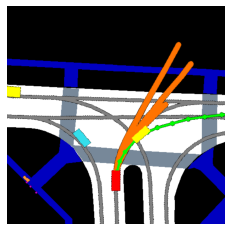

Epoch 13; Train loss: 1.37; Val loss: 9.03; Best VL: 3.43; Time: 928.17 sec;


In [37]:
fit(config.epoch, model, loss_function, optimizer, train_dl, validation_dl, validation_ds, valid_samples)

### Check results

In [ ]:
def draw_prediction_on_canvas(ground_truth, trajectories, probabilities):

    print('Trajectories probabilities')
    print(probabilities)
    
    PlotPathWithPrediction(ground_truth, trajectories)

In [ ]:
img, state, gt = train_ds[2]

img = img.unsqueeze(0)
state = state.unsqueeze(0)

In [ ]:
gt[0].shape

In [ ]:
traj, prob = get_predictions(model, img, state)

traj.shape, prob.shape

In [ ]:
prob

In [ ]:
def PlotPathWithPrediction(future, predict_trajectories=[]):
    plt.figure(figsize=(6, 6))

    plt.scatter(future[:, 1], -future[:, 0], c='g', s=10)
    
    for trajectory in predict_trajectories:
        plt.scatter(trajectory[:, 1], -trajectory[:, 0], c='yellow', s=10)

    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()

In [ ]:
PlotPathWithPrediction(gt[0], traj[:1])